In [16]:
import numpy as np
import matplotlib.pylab as pl
import pandas as pd
import matplotlib.pyplot as plt
from skimage.color import label2rgb
from scipy.spatial import ConvexHull
from concave_hull import concave_hull, concave_hull_indexes
from scipy.spatial import Delaunay
from scipy.ndimage import gaussian_filter
from scipy.spatial import distance
import heapq
import random
from collections import deque
from scipy.spatial import distance
import networkx as nx
import random
from scipy.ndimage import gaussian_filter, binary_dilation, label, generate_binary_structure
from scipy.sparse.csgraph import minimum_spanning_tree
import cv2
from skimage import transform as tf
from scipy.spatial import KDTree
import os
from skimage.morphology import skeletonize
from skimage.draw import disk

# Ici on mettre a première partie de code qui permet de pré traiter la vidéo :
Gif -> images
image0 -> grille utilisable pour le RD simulator\
Là j'ai juste mis un exemple, on part d'un grille déjà construire hors de ce dossier pour le moment

# Reaction-Diffusion Simulator

This part should be done in the RD file to get the grid corresponding to the image
In the following code are several examples so you don't have to generate them.

# Traitement de la grille obtenue après génération du pattern

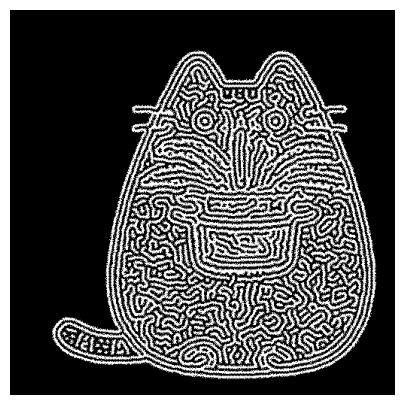

In [17]:
def load_grid(csv_path):
    return pd.read_csv(csv_path, header=None).values

def save_to_csv(grid, file_path):
    df = pd.DataFrame(grid)
    df.to_csv(file_path, header=False, index=False)

    

csv_path = 'example_grids/cat.csv'
# csv_path = 'example_grids/lemon.csv'    Another example

grille = load_grid(csv_path)

plt.figure(figsize=(5, 5))
plt.axis('off')
plt.imshow(grille, cmap='gray')
plt.show()

The setup function does three things:

-It smooths the image to eliminate stray pixels\
-It binarizes the image, converting pixels to values of 0 or 1\
-It transforms each wall into a one-pixel-thick line

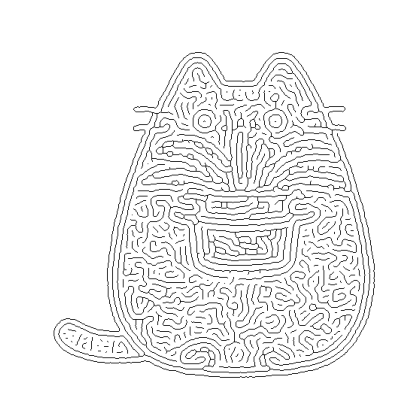

In [18]:
def setup(g):
    grille_lissée = gaussian_filter(g.astype(float), sigma=1)
    grille_binaire =(grille_lissée > 0.5).astype(int)
    grille_binaire=1-skeletonize(grille_binaire)
    return grille_binaire


grille_binaire=setup(grille)

plt.figure(figsize=(5, 5))
plt.imshow(grille_binaire, cmap='gray')
plt.axis('off')
plt.show()

# Making the maze solvable

The obtained grid is processed to create a maze, and then the image can be saved.\
Once this part is working well, it will be interesting to place it BEFORE the pixel movement to avoid repeating the step each time.

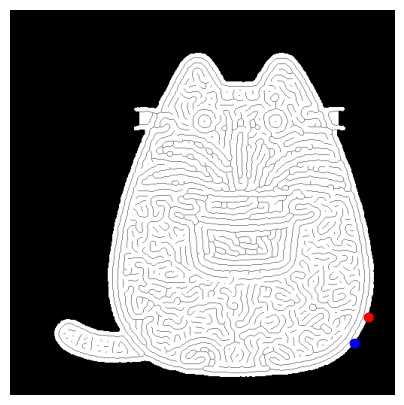

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from shapely.geometry import Point, Polygon

grid = grille_binaire

points = np.column_stack(np.where(grid == 0))
convex_hull = ConvexHull(points)

length_threshold = 1
idxes = concave_hull_indexes(points, length_threshold=length_threshold) # non unicité à préciser
assert np.all(points[idxes] == concave_hull(points, length_threshold=length_threshold))

grid_clone = grid.copy()

start_point = points[np.random.choice(idxes)]
end_point = points[np.random.choice(idxes)]



grid_clone[start_point[0], start_point[1]] = 1
grid_clone[end_point[0], end_point[1]] = 1


# polygone avec les points de l'enveloppe concave
hull_points = points[idxes]
polygon = Polygon(hull_points)

# Marquer l'exterieur
for x in range(grid.shape[0]):
    for y in range(grid.shape[1]):
        if not polygon.contains(Point(x, y)):
            grid_clone[x, y] = -1

plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(grid_clone, cmap='gray')
plt.scatter(start_point[1], start_point[0], color='red')
plt.scatter(end_point[1], end_point[0], color='blue')
plt.show()

save_g=grid_clone


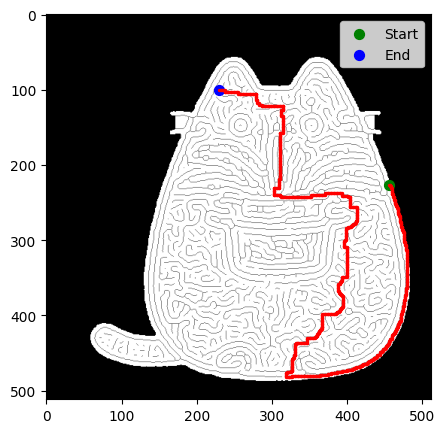

1161


In [20]:
grid_clone=save_g

def is_valid_move(grid, weights, x, y):
    rows = len(grid)
    cols = len(grid[0])
    if 0 <= x < rows and 0 <= y < cols and grid[x][y] == 1:
        return True, weights[x][y]
    return False, None

def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def astar(grid, weights, start, end):
    rows, cols = len(grid), len(grid[0])
    start, end = tuple(start), tuple(end)
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {start: 0}
    f_score = {start: heuristic(start, end)}
    
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    
    while open_set:
        _, current = heapq.heappop(open_set)
        
        if current == end:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            return path[::-1]
        
        for direction in directions:
            neighbor = (current[0] + direction[0], current[1] + direction[1])
            valid_move, move_cost = is_valid_move(grid, weights, neighbor[0], neighbor[1])
            if valid_move:
                tentative_g_score = g_score[current] + move_cost
                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + heuristic(neighbor, end)
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))
    
    return None

weights = np.random.randint(1, 10, (512, 512))
weights = np.ones((512,512))


from scipy.spatial.distance import cdist
h = points[convex_hull.vertices]
radius = 10
for hp in h:
    distances = cdist([hp], points, 'euclidean')[0]
    for idx, dist in enumerate(distances):
        if dist <= radius:
            px, py = points[idx]
            weights[px, py] = 0

def plot_grid_with_path(grid, path, start, end):
    plt.figure(figsize=(5, 5))
    plt.imshow(grid, cmap='gray')
    
    plt.scatter(start[1], start[0], color='green', s=50, label='Start')
    plt.scatter(end[1], end[0], color='blue', s=50, label='End')
    
    for (x, y) in path:
        plt.scatter(y, x, color='red', s=2)
    
    plt.legend()
    plt.show()


end_point = [100, 230]
longest_path = None
longest_length = 0
best_start_point = None

for i in range(512):
    if grid_clone[i,300]==0:
        a=random.randint(-50,50)
        for k in range(-3,3):
            for l in range(-3,3):
                grid_clone[i+k,300+a+l]=1



grid_clone[end_point[0], end_point[1]] = 1

points = np.array([(i, j) for i in range(512) for j in range(512) if grid_clone[i, j] == 1])
points_selected_indices = np.random.choice(len(points), 200, replace=False)
points_selected = points[points_selected_indices]

for start_point in points_selected:
    path = astar(grid_clone, weights, (start_point[0], start_point[1]), (end_point[0], end_point[1]))
    if path and len(path) > longest_length:
        longest_length = len(path)
        longest_path = path
        best_start_point = start_point


if longest_path:
    path=longest_path


if path:
    plot_grid_with_path(grid_clone, path, best_start_point, end_point)
    print(len(path))
else:
    print("No path: error")


On a désormais un labyrinthe, avec un point de départ, d'arrivée, et un chemin entre les deux (faut juste faire en sorte que le chemin soit plus long mais on verra après) \
Maintenant comme on veut que le chemin choisi soit unique, on va relier tous les autres murs (mettre le pseudo code de l'algo 2)

207


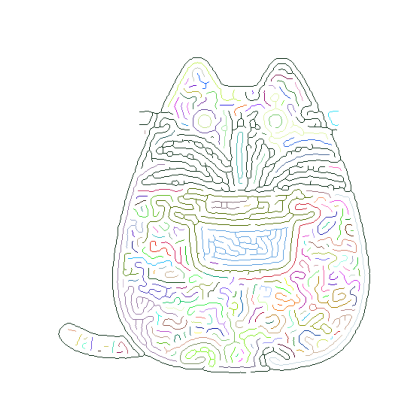

In [21]:
grid=grid_clone*grid_clone
grid=1-grid


structure = generate_binary_structure(2, 2)
labeled_grid, num_features = label(grid, structure=structure)
new_grid = np.copy(labeled_grid)

n_suppr=0
for i in range(1, num_features + 1):
    if np.sum(labeled_grid == i) < 4:
        new_grid[labeled_grid == i] = 0
        n_suppr+=1



labeled_grid_3d = np.zeros((grid.shape[0], grid.shape[1], 3), dtype=np.uint8)
colors = {}
for i in range(1, num_features + 1):
    if np.sum(labeled_grid == i) >= 4:
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        colors[i] = color
        labeled_grid_3d[new_grid == i] = color


num_features=num_features-n_suppr
print(num_features)
plt.figure(figsize=(5, 5))
plt.imshow(255 - labeled_grid_3d)
plt.axis('off')
plt.show()

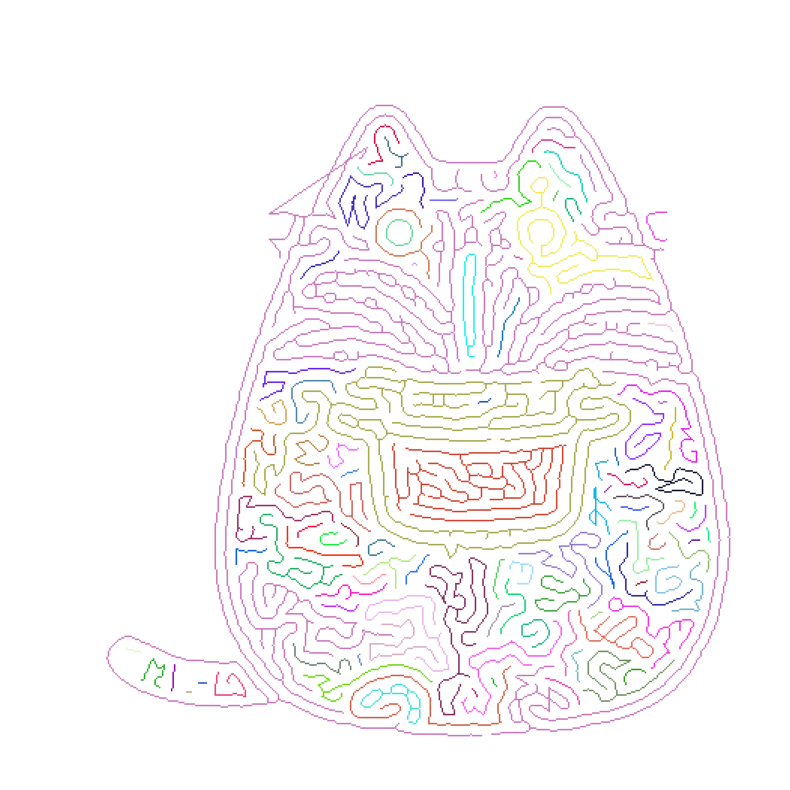

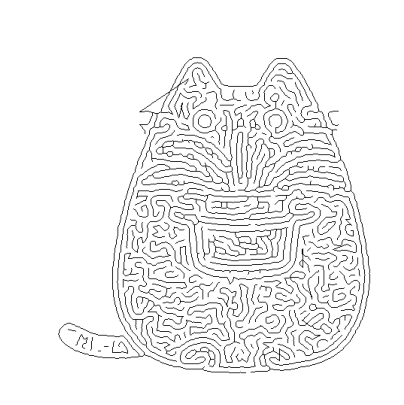

In [22]:
# this can take a few minutes to execute

def find_endpoints(label_grid, group_id):
    positions = np.column_stack(np.where(label_grid == group_id))
    endpoints = []
    for pos in positions:
        x, y = pos
        neighbors = label_grid[x-1:x+2, y-1:y+2] == group_id
        if np.sum(neighbors) <= 2: 
            endpoints.append((x, y))
    return endpoints

maze_path = path
iteration=0
def distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def draw_line(grid, p1, p2, group_id):
    x1, y1 = p1
    x2, y2 = p2
    dx, dy = abs(x2 - x1), abs(y2 - y1)
    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1
    err = dx - dy

    while True:
        if grid[x1, y1] == 0 and (x1, y1) not in maze_path:
            grid[x1, y1] = group_id
        if (x1, y1) == (x2, y2):
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x1 += sx
        if e2 < dx:
            err += dx
            y1 += sy

def can_draw_line(grid, p1, p2, maze_path, group1, group2): #voir si ça coupe rien
    x1, y1 = p1
    x2, y2 = p2
    dx, dy = abs(x2 - x1), abs(y2 - y1)
    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1
    err = dx - dy

    while True:
        for nx in range(-1, 2):
            for ny in range(-1, 2):
                nx_x1 = x1 + nx
                ny_y1 = y1 + ny
                if (nx_x1, ny_y1) in maze_path or (0 <= nx_x1 < grid.shape[0] and 0 <= ny_y1 < grid.shape[1] and grid[nx_x1, ny_y1] > 0 and grid[nx_x1, ny_y1] != group1 and grid[nx_x1, ny_y1] != group2):
                    return False
        if (x1, y1) == (x2, y2):
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x1 += sx
        if e2 < dx:
            err += dx
            y1 += sy

    return True


start_num_features=num_features  #pour pouvoir modifier num_features pendant l'algo
#while num_features>2:      Theorical implementation, however often takes way too much time to run, we are fine with a few more groups, the path should still be unqiue
for _ in range(int(start_num_features/2)): # /2 to make it execute faster, path should be almost unique

    random_group = random.choice([i for i in range(1, num_features + 1) if np.sum(labeled_grid == i) >= 4])
    endpoints = find_endpoints(labeled_grid, random_group)

    closest_group = None
    closest_endpoint_point = None
    min_distance = float('inf')

    for i in range(1, num_features + 1):
            if i != random_group and np.sum(labeled_grid == i) >= 4:
                other_endpoints = find_endpoints(labeled_grid, i)
                for endpoint_point in endpoints:
                    for other_point in other_endpoints:
                        if can_draw_line(labeled_grid, endpoint_point, other_point, maze_path, random_group, i):
                            dist = distance(endpoint_point, other_point)
                            if dist < min_distance:
                                min_distance = dist
                                closest_group = i
                                closest_endpoint_point = other_point
                                closest_random_endpoint = endpoint_point


        # connect the 2 groups
    if closest_group is not None:
        draw_line(new_grid, closest_random_endpoint, closest_endpoint_point, random_group)
        new_grid[new_grid == closest_group] = random_group
        
        # Update labeled_grid and num_features to reflect the new state
        labeled_grid, num_features = label(new_grid, structure=structure)
            
        # make suree that the newly formed group has a color
        if random_group not in colors:
            colors[random_group] = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            
        labeled_grid_3d[new_grid == random_group] = colors[random_group]




colors = {}
for i in range(1, num_features + 1):  # une couleur par ligne
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    colors[i] = color
    labeled_grid_3d[labeled_grid == i] = color



plt.figure(figsize=(10, 10))
plt.imshow(255 - labeled_grid_3d)
plt.axis('off')
plt.show()


img = cv2.cvtColor(labeled_grid_3d, cv2.COLOR_RGB2GRAY)
grille_binaire=1-(img > 0).astype(int)
plt.figure(figsize=(5, 5))
plt.imshow(grille_binaire, cmap='gray')
plt.axis('off')
plt.show()
g1=grille_binaire # to be able to rerun the code without recalculating this binary grid (non-functional of f{i})

# Moving pixels

Here we don't do the entire process, we only do it from frame 0 to frame 1. A complete exemple would iteration through all the images. We can run the code from here after changing the image to "manually" do the iterations.

In [23]:
grid=1-g1  # got to inverse the grid once again

structure = generate_binary_structure(2, 2)  # 8-connectivity connection structure

labeled_grid, num_features = label(grid, structure=structure)

labeled_grid_3d = np.zeros((grid.shape[0], grid.shape[1], 3), dtype=np.uint8) # 3D matrix to record which line each point belongs to


colors = {}
for i in range(1, num_features + 1):
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    colors[i] = color
    labeled_grid_3d[labeled_grid == i] = color

In [24]:
f0 = cv2.imread('example_images/cat0.png', cv2.IMREAD_GRAYSCALE)
f1 = cv2.imread('example_images/cat1.png', cv2.IMREAD_GRAYSCALE)

#f0 = cv2.imread('example_images/lemon0.png', cv2.IMREAD_GRAYSCALE)
#f1 = cv2.imread('example_images/lemon1.png', cv2.IMREAD_GRAYSCALE)

Calculation of optical flow between images\
Next, we determine the transport plan\
And remap the grid

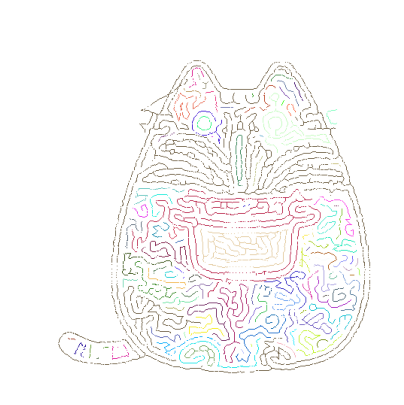

In [25]:
flow = cv2.calcOpticalFlowFarneback(f0, f1, None, 0.5, 3, 15, 3, 5, 1.2, 0)

# map for the coordinates' destinations
h, w = flow.shape[:2]
flow_map_x, flow_map_y = np.meshgrid(np.arange(w), np.arange(h))
flow_map = np.dstack((flow_map_x, flow_map_y)).astype(np.float32) + flow



moved_grid = np.zeros_like(labeled_grid_3d)

for y in range(h):
    for x in range(w):
        new_x = int(flow_map[y, x, 0])
        new_y = int(flow_map[y, x, 1])
        if 0 <= new_x < w and 0 <= new_y < h:
            moved_grid[new_y, new_x] = labeled_grid_3d[y, x]


plt.figure(figsize=(5,5))
plt.imshow(255-moved_grid)
plt.axis('off')
plt.show()

We can see that this has broken quite a few lines, which is normal since the transformation is injective in this case, so some destination points are not filled\
Now, we need to ensure that the lines are fully connected!\
It's looking pretty good; the method used is really not optimal, but that's okay.

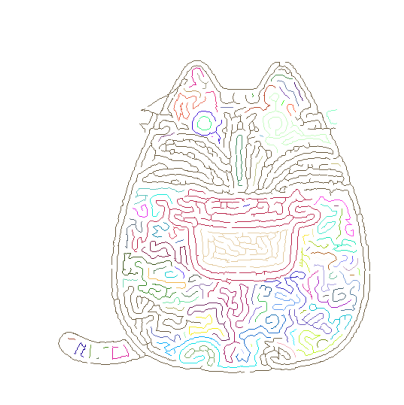

In [26]:
def connect_broken_lines(moved_grid):
    unique_colors = np.unique(moved_grid.reshape(-1, moved_grid.shape[2]), axis=0)
    unique_colors = unique_colors[np.any(unique_colors != [0, 0, 0], axis=1)]  # getting rid of black pixels

    for color in unique_colors:
        mask = np.all(moved_grid == color, axis=-1)  # keeping only a certain color
        points = np.argwhere(mask)

        if len(points) > 1:
            tree = KDTree(points)  # KDTree for 2D shortest path finding
            distances, indices = tree.query(points, k=len(points))

            # Créer une matrice de distances
            distance_matrix = np.zeros((len(points), len(points)))
            for i in range(len(points)):
                for j in range(1, len(points)):
                    distance_matrix[i, indices[i, j]] = distances[i, j]


            mst = minimum_spanning_tree(distance_matrix).toarray()

            # complete lines with MST
            for i in range(len(points)):
                for j in range(len(points)):
                    if mst[i, j] > 0:
                        point1 = points[i]
                        point2 = points[j]
                        rr, cc = drawLine(point1[0], point1[1], point2[0], point2[1])
                        moved_grid[rr, cc] = color

    return moved_grid




def drawLine(x0, y0, x1, y1):
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy

    while True:
        points.append((x0, y0))
        if x0 == x1 and y0 == y1:
            break
        e2 = err * 2
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
    rr, cc = zip(*points)
    return rr, cc




connected_moved_grid = connect_broken_lines(moved_grid)


plt.figure(figsize=(5, 5))
plt.imshow(255-connected_moved_grid)
plt.axis('off')
plt.show() #2-3 minute per frame

There are a few gaps due to the way we constructed the algorithm; we ensure that the lines of the same color form only one block, which allows gaps in certain places because, despite these gaps, the graph formed by points of the same color remains connected.

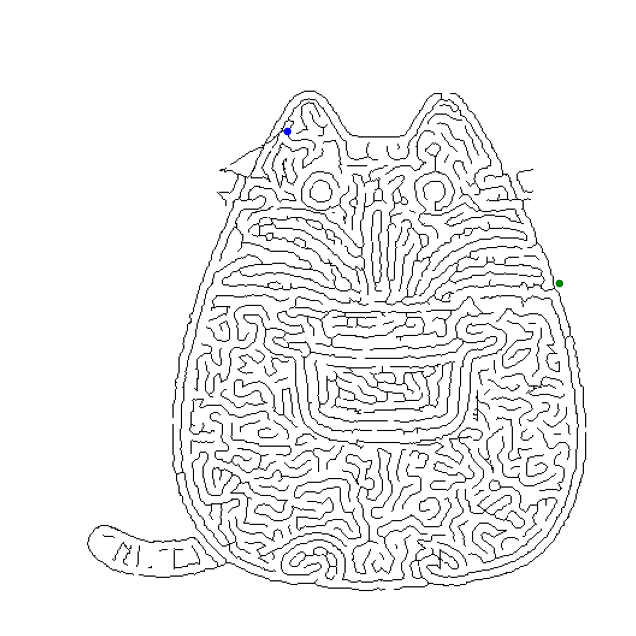

In [27]:
img = cv2.cvtColor(connected_moved_grid, cv2.COLOR_RGB2GRAY)
grille_binaire=1-(img > 0).astype(int)

plt.figure(figsize=(8, 8))
plt.imshow(grille_binaire, cmap='gray')
plt.scatter(best_start_point[1], best_start_point[0], color='green', s=20, label='Start')
plt.scatter(end_point[1], end_point[0], color='blue', s=20, label='End')
plt.axis('off')
plt.show()